# 🎯 Advanced Loss Functions - Segmentation Sémantique

## 🎯 Objectifs

**Mission** : Implémenter des fonctions de perte avancées adaptées au déséquilibre de classes

**Problématique** : Le dataset Cityscapes présente un fort déséquilibre :
- **Classes dominantes** : road (38.7%), building (21.7%), nature (15.2%)
- **Classes minoritaires** : person (1.2%), object (1.8%), sky (3.5%)
- **Impact** : Les classes dominantes "écrasent" les minoritaires durant l'entraînement

**Solutions implémentées** :
1. **Dice Loss** : Optimise directement l'IoU, robuste au déséquilibre
2. **Focal Loss** : Focalise sur les exemples difficiles
3. **Weighted Cross-Entropy** : Pondération inverse de fréquence
4. **Combined Loss** : Hybridation des approches
5. **Class-balanced metrics** : Évaluation équitable par classe

---

## 📚 Imports et Configuration

In [1]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import numpy as np
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import Loss
from tensorflow.keras.metrics import Metric
import tensorflow.keras.metrics as metrics

# Configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Chemins du projet
PROJECT_ROOT = Path("C:/Tonton/OpenClassrooms/Projet_7_traiter_images_systeme_embarque_voiture_autonome")
NOTEBOOKS_DIR = PROJECT_ROOT / "notebooks"
OUTPUTS_DIR = NOTEBOOKS_DIR / "outputs"
FIGURES_DIR = NOTEBOOKS_DIR / "figures"

print("✅ Configuration chargée")
print(f"🔗 TensorFlow: {tf.__version__}")
print(f"🎯 Implémentation de fonctions de perte avancées")


✅ Configuration chargée
🔗 TensorFlow: 2.15.1
🎯 Implémentation de fonctions de perte avancées


## 🔍 Analyse du Déséquilibre des Classes

In [2]:
# Charger les données de distribution des classes
try:
    df_distribution = pd.read_csv(OUTPUTS_DIR / "8_categories_distribution.csv")
    
    # Calcul des poids de classes (inverse de la fréquence)
    class_weights = {}
    for _, row in df_distribution.iterrows():
        category = row['category']
        percentage = row['percentage']
        index = row['index']
        
        # Poids = 1 / fréquence_relative, normalisé
        weight = 100.0 / percentage
        class_weights[index] = weight
    
    # Normalisation des poids (moyenne = 1)
    mean_weight = np.mean(list(class_weights.values()))
    class_weights = {k: v/mean_weight for k, v in class_weights.items()}
    
    print("📊 ANALYSE DU DÉSÉQUILIBRE DES CLASSES")
    print("=" * 50)
    print("Distribution actuelle:")
    for _, row in df_distribution.iterrows():
        print(f"   {int(row['index'])}. {row['category'].upper():12}: {row['percentage']:6.2f}%")
    
    print(f"\n⚖️ Poids calculés (inverse fréquence):")
    for idx in sorted(class_weights.keys()):
        category = df_distribution[df_distribution['index'] == idx]['category'].iloc[0]
        print(f"   {idx}. {category.upper():12}: {class_weights[idx]:6.2f}")
    
except FileNotFoundError:
    print("⚠️ Fichier de distribution non trouvé, utilisation de poids par défaut")
    class_weights = {0: 1.0, 1: 1.5, 2: 2.8, 3: 2.1, 4: 4.5, 5: 41.7, 6: 5.4, 7: 3.8}

# Configuration des poids
LOSS_CONFIG = {
    'num_classes': 8,
    'class_weights': class_weights,
    'smooth': 2e-6,  # Facteur de lissage pour éviter division par zéro
    'alpha': 0.25,   # Paramètre Focal Loss
    'gamma': 2.0     # Paramètre Focal Loss
}

📊 ANALYSE DU DÉSÉQUILIBRE DES CLASSES
Distribution actuelle:
   0. ROAD        :  38.73%
   1. BUILDING    :  21.72%
   3. NATURE      :  15.23%
   7. VOID        :  10.50%
   6. VEHICLE     :   7.32%
   4. SKY         :   3.47%
   2. OBJECT      :   1.81%
   5. PERSON      :   1.22%

⚖️ Poids calculés (inverse fréquence):
   0. ROAD        :   0.10
   1. BUILDING    :   0.18
   2. OBJECT      :   2.18
   3. NATURE      :   0.26
   4. SKY         :   1.13
   5. PERSON      :   3.23
   6. VEHICLE     :   0.54
   7. VOID        :   0.37


## 🎲 Dice Loss - Optimisation Directe de l'IoU

**Principe** : Optimise directement le coefficient de Dice (2×IoU/(IoU+1))

**Avantages** :
- Insensible au déséquilibre des classes
- Optimise directement la métrique d'évaluation
- Stable numériquement avec facteur de lissage

In [3]:
class DiceLoss(Loss):
    """
    Dice Loss pour segmentation sémantique multi-classe
    
    Formule: 1 - (2 * intersection + smooth) / (union + smooth)
    où intersection = sum(y_true * y_pred) et union = sum(y_true) + sum(y_pred)
    """
    
    def __init__(self, smooth=1e-6, per_class=True, name='dice_loss'):
        super().__init__(name=name)
        self.smooth = smooth
        self.per_class = per_class
    
    def call(self, y_true, y_pred):
        # Conversion en one-hot si nécessaire
        if len(y_true.shape) == 3:  # Labels entiers (batch, height, width)
            y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])
        
        # Aplatissement pour calcul plus facile
        y_true_flat = tf.reshape(y_true, [-1, y_pred.shape[-1]])
        y_pred_flat = tf.reshape(y_pred, [-1, y_pred.shape[-1]])
        
        if self.per_class:
            # Dice par classe puis moyenne
            intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=0)
            union = tf.reduce_sum(y_true_flat, axis=0) + tf.reduce_sum(y_pred_flat, axis=0)
            dice_scores = (2. * intersection + self.smooth) / (union + self.smooth)
            return 1 - tf.reduce_mean(dice_scores)
        else:
            # Dice global
            intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
            union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)
            dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
            return 1 - dice_score

class DiceCoefficient(Metric):
    """
    Métrique Dice Coefficient (complémentaire à la loss)
    """
    
    def __init__(self, smooth=1e-6, name='dice_coefficient'):
        super().__init__(name=name)
        self.smooth = smooth
        self.dice_sum = self.add_weight(name='dice_sum', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        if len(y_true.shape) == 3:
            y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])
        
        y_true_flat = tf.reshape(y_true, [-1, y_pred.shape[-1]])
        y_pred_flat = tf.reshape(y_pred, [-1, y_pred.shape[-1]])
        
        intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=0)
        union = tf.reduce_sum(y_true_flat, axis=0) + tf.reduce_sum(y_pred_flat, axis=0)
        dice_scores = (2. * intersection + self.smooth) / (union + self.smooth)
        
        self.dice_sum.assign_add(tf.reduce_mean(dice_scores))
        self.count.assign_add(1.0)
    
    def result(self):
        return self.dice_sum / self.count
    
    def reset_state(self):
        self.dice_sum.assign(0.0)
        self.count.assign(0.0)

# Test de la Dice Loss
print("\n🎲 TEST DICE LOSS")
print("=" * 30)

# Données de test
y_true_test = tf.random.uniform((2, 64, 64), maxval=8, dtype=tf.int32)
y_pred_test = tf.random.uniform((2, 64, 64, 8))
y_pred_test = tf.nn.softmax(y_pred_test)  # Normalisation softmax

dice_loss = DiceLoss()
dice_metric = DiceCoefficient()

loss_value = dice_loss(y_true_test, y_pred_test)
dice_metric.update_state(y_true_test, y_pred_test)
metric_value = dice_metric.result()

print(f"✅ Dice Loss: {loss_value:.6f}")
print(f"✅ Dice Coefficient: {metric_value:.6f}")
print(f"✅ Relation: Loss + Coefficient ≈ 1.0 : {loss_value + metric_value:.6f}")


🎲 TEST DICE LOSS

✅ Dice Loss: 0.874345
✅ Dice Coefficient: 0.125655
✅ Relation: Loss + Coefficient ≈ 1.0 : 1.000000


## 🔥 Focal Loss - Focus sur les Exemples Difficiles

**Principe** : Réduit l'influence des exemples faciles, focalise sur les difficiles

**Formule** : FL = -α(1-pt)^γ log(pt)
- α : facteur de pondération des classes
- γ : facteur de focalisation (plus élevé = plus de focus sur difficile)
- pt : probabilité prédite pour la vraie classe

In [4]:
class FocalLoss(Loss):
    """
    Focal Loss pour gérer les classes déséquilibrées et exemples difficiles
    
    Args:
        alpha: Facteur de pondération des classes (float ou dict)
        gamma: Facteur de focalisation (default: 2.0)
        class_weights: Dictionnaire de poids par classe
    """
    
    def __init__(self, alpha=0.25, gamma=2.0, class_weights=None, name='focal_loss'):
        super().__init__(name=name)
        self.alpha = alpha
        self.gamma = gamma
        self.class_weights = class_weights
    
    def call(self, y_true, y_pred):
        # Conversion en one-hot si nécessaire
        if len(y_true.shape) == 3:
            y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])
        
        # Clipping pour stabilité numérique
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        
        # Calcul de la cross-entropy
        ce_loss = -y_true * tf.math.log(y_pred)
        
        # Probabilité de la vraie classe
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        
        # Facteur de focalisation
        focal_weight = tf.pow(1 - pt, self.gamma)
        
        # Application du facteur alpha si fourni
        if isinstance(self.alpha, (float, int)):
            alpha_weight = y_true * self.alpha + (1 - y_true) * (1 - self.alpha)
            focal_loss = alpha_weight * focal_weight * ce_loss
        else:
            focal_loss = focal_weight * ce_loss
        
        # Application des poids de classes si fournis
        if self.class_weights is not None:
            # Création du tenseur de poids
            weights_tensor = tf.constant([self.class_weights.get(i, 1.0) 
                                        for i in range(y_pred.shape[-1])], dtype=tf.float32)
            class_weights_expanded = tf.expand_dims(tf.expand_dims(weights_tensor, 0), 0)
            focal_loss = focal_loss * class_weights_expanded
        
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

# Test de la Focal Loss
print("\n🔥 TEST FOCAL LOSS")
print("=" * 30)

focal_loss = FocalLoss(alpha=LOSS_CONFIG['alpha'], 
                      gamma=LOSS_CONFIG['gamma'], 
                      class_weights=LOSS_CONFIG['class_weights'])

focal_value = focal_loss(y_true_test, y_pred_test)
print(f"✅ Focal Loss: {focal_value:.6f}")

# Comparaison avec Cross-Entropy standard
ce_loss = tf.keras.losses.SparseCategoricalCrossentropy()
ce_value = ce_loss(y_true_test, y_pred_test)
print(f"✅ Cross-Entropy standard: {ce_value:.6f}")
print(f"✅ Ratio Focal/CE: {focal_value/ce_value:.3f}")


🔥 TEST FOCAL LOSS
✅ Focal Loss: 0.414262
✅ Cross-Entropy standard: 2.110148
✅ Ratio Focal/CE: 0.196


## ⚖️ Weighted Cross-Entropy - Pondération par Classe

**Principe** : Applique des poids différents selon la rareté des classes

In [5]:
class WeightedCategoricalCrossentropy(Loss):
    """
    Cross-Entropy pondérée avec poids par classe
    """
    
    def __init__(self, class_weights, name='weighted_ce_loss'):
        super().__init__(name=name)
        self.class_weights = class_weights
        
    def call(self, y_true, y_pred):
        # Conversion en one-hot si nécessaire
        if len(y_true.shape) == 3:
            y_true_indices = tf.cast(y_true, tf.int32)
            y_true = tf.one_hot(y_true_indices, depth=y_pred.shape[-1])
        else:
            y_true_indices = tf.argmax(y_true, axis=-1)
        
        # Clipping pour stabilité
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        
        # Cross-entropy
        ce_loss = -y_true * tf.math.log(y_pred)
        
        # Application des poids
        weights_tensor = tf.constant([self.class_weights.get(i, 1.0) 
                                    for i in range(y_pred.shape[-1])], dtype=tf.float32)
        
        # Expansion pour broadcasting
        weights_expanded = tf.expand_dims(tf.expand_dims(weights_tensor, 0), 0)
        weighted_loss = ce_loss * weights_expanded
        
        return tf.reduce_mean(tf.reduce_sum(weighted_loss, axis=-1))

# Test Weighted Cross-Entropy
print("\n⚖️ TEST WEIGHTED CROSS-ENTROPY")
print("=" * 40)

weighted_ce = WeightedCategoricalCrossentropy(class_weights=LOSS_CONFIG['class_weights'])
weighted_value = weighted_ce(y_true_test, y_pred_test)

print(f"✅ Weighted CE: {weighted_value:.6f}")
print(f"✅ CE standard: {ce_value:.6f}")
print(f"✅ Amplification: {weighted_value/ce_value:.3f}x")


⚖️ TEST WEIGHTED CROSS-ENTROPY
✅ Weighted CE: 2.143056
✅ CE standard: 2.110148
✅ Amplification: 1.016x


## 🎭 Combined Loss - Hybridation des Approches

**Principe** : Combine plusieurs losses pour bénéficier de leurs avantages complémentaires

In [6]:
class CombinedLoss(Loss):
    """
    Loss hybride combinant Dice, Focal et Weighted Cross-Entropy
    
    Formula: Total = w1*Dice + w2*Focal + w3*WeightedCE
    """
    
    def __init__(self, weights={'dice': 0.5, 'focal': 0.3, 'weighted_ce': 0.2}, 
                 focal_params={'alpha': 0.25, 'gamma': 2.0},
                 class_weights=None, name='combined_loss'):
        super().__init__(name=name)
        self.weights = weights
        self.focal_params = focal_params
        self.class_weights = class_weights
        
        # Initialisation des losses composantes
        self.dice_loss = DiceLoss()
        self.focal_loss = FocalLoss(alpha=focal_params['alpha'], 
                                   gamma=focal_params['gamma'],
                                   class_weights=class_weights)
        self.weighted_ce = WeightedCategoricalCrossentropy(class_weights=class_weights)
        
    def call(self, y_true, y_pred):
        # Calcul de chaque composante
        dice_component = self.dice_loss(y_true, y_pred)
        focal_component = self.focal_loss(y_true, y_pred)
        weighted_ce_component = self.weighted_ce(y_true, y_pred)
        
        # Combinaison pondérée
        total_loss = (self.weights['dice'] * dice_component + 
                     self.weights['focal'] * focal_component + 
                     self.weights['weighted_ce'] * weighted_ce_component)
        
        return total_loss
    
    def get_component_losses(self, y_true, y_pred):
        """Retourne les losses individuelles pour debug"""
        return {
            'dice': self.dice_loss(y_true, y_pred),
            'focal': self.focal_loss(y_true, y_pred),
            'weighted_ce': self.weighted_ce(y_true, y_pred)
        }

# Test Combined Loss
print("\n🎭 TEST COMBINED LOSS")
print("=" * 30)

combined_loss = CombinedLoss(
    weights={'dice': 0.5, 'focal': 0.3, 'weighted_ce': 0.2},
    focal_params={'alpha': LOSS_CONFIG['alpha'], 'gamma': LOSS_CONFIG['gamma']},
    class_weights=LOSS_CONFIG['class_weights']
)

combined_value = combined_loss(y_true_test, y_pred_test)
components = combined_loss.get_component_losses(y_true_test, y_pred_test)

print(f"✅ Combined Loss: {combined_value:.6f}")
print(f"   • Composante Dice: {components['dice']:.6f}")
print(f"   • Composante Focal: {components['focal']:.6f}")  
print(f"   • Composante Weighted CE: {components['weighted_ce']:.6f}")


🎭 TEST COMBINED LOSS
✅ Combined Loss: 0.990063
   • Composante Dice: 0.874345
   • Composante Focal: 0.414262
   • Composante Weighted CE: 2.143056


## 📊 Métriques de Segmentation Avancées

**Objectif** : Métriques équitables pour évaluation multi-classe

In [7]:
class IoUPerClass(Metric):
    """
    IoU (Intersection over Union) calculé pour chaque classe individuellement
    """
    def __init__(self, num_classes, name='iou_per_class'):
        super().__init__(name=name)
        self.num_classes = num_classes
        self.iou_sum = self.add_weight(name='iou_sum', initializer='zeros', shape=(num_classes,))
        self.count = self.add_weight(name='count', initializer='zeros')
        self.class_indices = tf.reshape(tf.range(num_classes, dtype=tf.int32), (-1, 1))

    def update_state(self, y_true, y_pred, sample_weight=None):
        if len(y_true.shape) == 3:
            y_true_classes = tf.cast(y_true, tf.int32)
        else:
            y_true_classes = tf.cast(tf.argmax(y_true, axis=-1), tf.int32)
        y_pred_classes = tf.cast(tf.argmax(y_pred, axis=-1), tf.int32)

        ious = []
        for class_id in range(self.num_classes):
            true_mask = tf.equal(y_true_classes, class_id)
            pred_mask = tf.equal(y_pred_classes, class_id)
            intersection = tf.reduce_sum(tf.cast(true_mask & pred_mask, tf.float32))
            union = tf.reduce_sum(tf.cast(true_mask | pred_mask, tf.float32))
            iou = tf.where(union > 0, intersection / union, 1.0)
            ious.append(iou)
        ious = tf.stack(ious)

        self.iou_sum.assign(tf.tensor_scatter_nd_add(self.iou_sum, self.class_indices, ious))
        self.count.assign_add(1.0)

    def result(self):
        return self.iou_sum / self.count

    def reset_state(self):
        self.iou_sum.assign(tf.zeros((self.num_classes,)))
        self.count.assign(0.0)

class MeanIoU(Metric):
    """
    mIoU (mean Intersection over Union) - métrique principale de segmentation
    """
    def __init__(self, num_classes, name='mean_iou'):
        super().__init__(name=name)
        self.iou_per_class = IoUPerClass(num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.iou_per_class.update_state(y_true, y_pred, sample_weight)

    def result(self):
        per_class_iou = self.iou_per_class.result()
        return tf.reduce_mean(per_class_iou)

    def reset_state(self):
        self.iou_per_class.reset_state()

class PixelAccuracy(Metric):
    """
    Précision au pixel (métrique globale)
    """
    def __init__(self, name='pixel_accuracy'):
        super().__init__(name=name)
        self.correct_pixels = self.add_weight(name='correct', initializer='zeros')
        self.total_pixels = self.add_weight(name='total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Normalisation des classes en int32
        if len(y_true.shape) == 3:
            y_true_classes = tf.cast(y_true, tf.int32)
        else:
            y_true_classes = tf.cast(tf.argmax(y_true, axis=-1), tf.int32)
        y_pred_classes = tf.cast(tf.argmax(y_pred, axis=-1), tf.int32)

        correct = tf.cast(tf.equal(y_true_classes, y_pred_classes), tf.float32)
        self.correct_pixels.assign_add(tf.reduce_sum(correct))
        self.total_pixels.assign_add(tf.cast(tf.size(y_true_classes), tf.float32))

    def result(self):
        return self.correct_pixels / self.total_pixels

    def reset_state(self):
        self.correct_pixels.assign(0.0)
        self.total_pixels.assign(0.0)


# Test des métriques
print("\n📊 TEST MÉTRIQUES AVANCÉES")
print("=" * 40)

# Initialisation des métriques
iou_per_class = IoUPerClass(LOSS_CONFIG['num_classes'])
mean_iou = MeanIoU(LOSS_CONFIG['num_classes'])
pixel_acc = PixelAccuracy()

# Mise à jour avec données de test
iou_per_class.update_state(y_true_test, y_pred_test)
mean_iou.update_state(y_true_test, y_pred_test)
pixel_acc.update_state(y_true_test, y_pred_test)

# Résultats
per_class_results = iou_per_class.result()
miou_result = mean_iou.result()
pixel_acc_result = pixel_acc.result()

print(f"✅ mIoU: {miou_result:.4f}")
print(f"✅ Pixel Accuracy: {pixel_acc_result:.4f}")
print(f"✅ IoU par classe:")
for i in range(LOSS_CONFIG['num_classes']):
    print(f"   Classe {i}: {per_class_results[i]:.4f}")


📊 TEST MÉTRIQUES AVANCÉES
✅ mIoU: 0.0645
✅ Pixel Accuracy: 0.1210
✅ IoU par classe:
   Classe 0: 0.0525
   Classe 1: 0.0792
   Classe 2: 0.0616
   Classe 3: 0.0619
   Classe 4: 0.0647
   Classe 5: 0.0688
   Classe 6: 0.0610
   Classe 7: 0.0659


## 🔧 Utilitaires pour Configuration d'Entraînement

In [8]:
def create_loss_configuration():
    """
    Crée les configurations de loss pour différents scénarios d'entraînement
    """
    
    configurations = {
        'baseline': {
            'loss': 'sparse_categorical_crossentropy',
            'description': 'Cross-entropy standard pour référence',
            'use_case': 'Baseline rapide, test de faisabilité',
            'expected_performance': 'Moyen, biais vers classes dominantes'
        },
        'weighted_ce': {
            'loss_class': 'WeightedCategoricalCrossentropy',
            'params': {'class_weights': LOSS_CONFIG['class_weights']},
            'description': 'Cross-entropy avec pondération inverse fréquence',
            'use_case': 'Correction déséquilibre classes',
            'expected_performance': 'Bon pour classes minoritaires'
        },
        'dice_optimized': {
            'loss_class': 'DiceLoss',
            'params': {'smooth': LOSS_CONFIG['smooth'], 'per_class': True},
            'description': 'Optimisation directe IoU/Dice',
            'use_case': 'Maximisation métrique d\'évaluation',
            'expected_performance': 'Excellent pour IoU, stable'
        },
        'focal_balanced': {
            'loss_class': 'FocalLoss',
            'params': {
                'alpha': LOSS_CONFIG['alpha'],
                'gamma': LOSS_CONFIG['gamma'],
                'class_weights': LOSS_CONFIG['class_weights']
            },
            'description': 'Focus sur exemples difficiles + pondération',
            'use_case': 'Classes déséquilibrées + exemples difficiles',
            'expected_performance': 'Très bon pour cas complexes'
        },
        'combined_optimal': {
            'loss_class': 'CombinedLoss',
            'params': {
                'weights': {'dice': 0.5, 'focal': 0.3, 'weighted_ce': 0.2},
                'focal_params': {'alpha': LOSS_CONFIG['alpha'], 'gamma': LOSS_CONFIG['gamma']},
                'class_weights': LOSS_CONFIG['class_weights']
            },
            'description': 'Hybridation Dice + Focal + Weighted CE',
            'use_case': 'Performance maximale, toutes situations',
            'expected_performance': 'Optimal, convergence stable'
        }
    }
    
    return configurations

def create_metrics_suite():
    """
    Crée une suite complète de métriques pour l'évaluation
    """
    
    metrics_config = {
        'primary_metrics': [
            {'class': MeanIoU, 'params': {'num_classes': LOSS_CONFIG['num_classes']}, 'name': 'mean_iou'},
            {'class': DiceCoefficient, 'params': {}, 'name': 'dice_coefficient'},
            {'class': PixelAccuracy, 'params': {}, 'name': 'pixel_accuracy'}
        ],
        'detailed_metrics': [
            {'class': IoUPerClass, 'params': {'num_classes': LOSS_CONFIG['num_classes']}, 'name': 'iou_per_class'}
        ],
        'standard_metrics': [
            'accuracy',  # Keras standard
            'sparse_categorical_accuracy'  # Pour labels entiers
        ]
    }
    
    return metrics_config

# Génération des configurations
loss_configs = create_loss_configuration()
metrics_suite = create_metrics_suite()

print("\n🔧 CONFIGURATIONS DE LOSS DISPONIBLES")
print("=" * 50)

for config_name, config_details in loss_configs.items():
    print(f"\n📋 {config_name.upper()}:")
    print(f"   • Loss: {config_details.get('loss_class', config_details.get('loss'))}")
    print(f"   • Description: {config_details['description']}")
    print(f"   • Cas d'usage: {config_details['use_case']}")


🔧 CONFIGURATIONS DE LOSS DISPONIBLES

📋 BASELINE:
   • Loss: sparse_categorical_crossentropy
   • Description: Cross-entropy standard pour référence
   • Cas d'usage: Baseline rapide, test de faisabilité

📋 WEIGHTED_CE:
   • Loss: WeightedCategoricalCrossentropy
   • Description: Cross-entropy avec pondération inverse fréquence
   • Cas d'usage: Correction déséquilibre classes

📋 DICE_OPTIMIZED:
   • Loss: DiceLoss
   • Description: Optimisation directe IoU/Dice
   • Cas d'usage: Maximisation métrique d'évaluation

📋 FOCAL_BALANCED:
   • Loss: FocalLoss
   • Description: Focus sur exemples difficiles + pondération
   • Cas d'usage: Classes déséquilibrées + exemples difficiles

📋 COMBINED_OPTIMAL:
   • Loss: CombinedLoss
   • Description: Hybridation Dice + Focal + Weighted CE
   • Cas d'usage: Performance maximale, toutes situations


## 📈 Comparaison Expérimentale des Losses


📈 COMPARAISON EXPÉRIMENTALE DES LOSSES


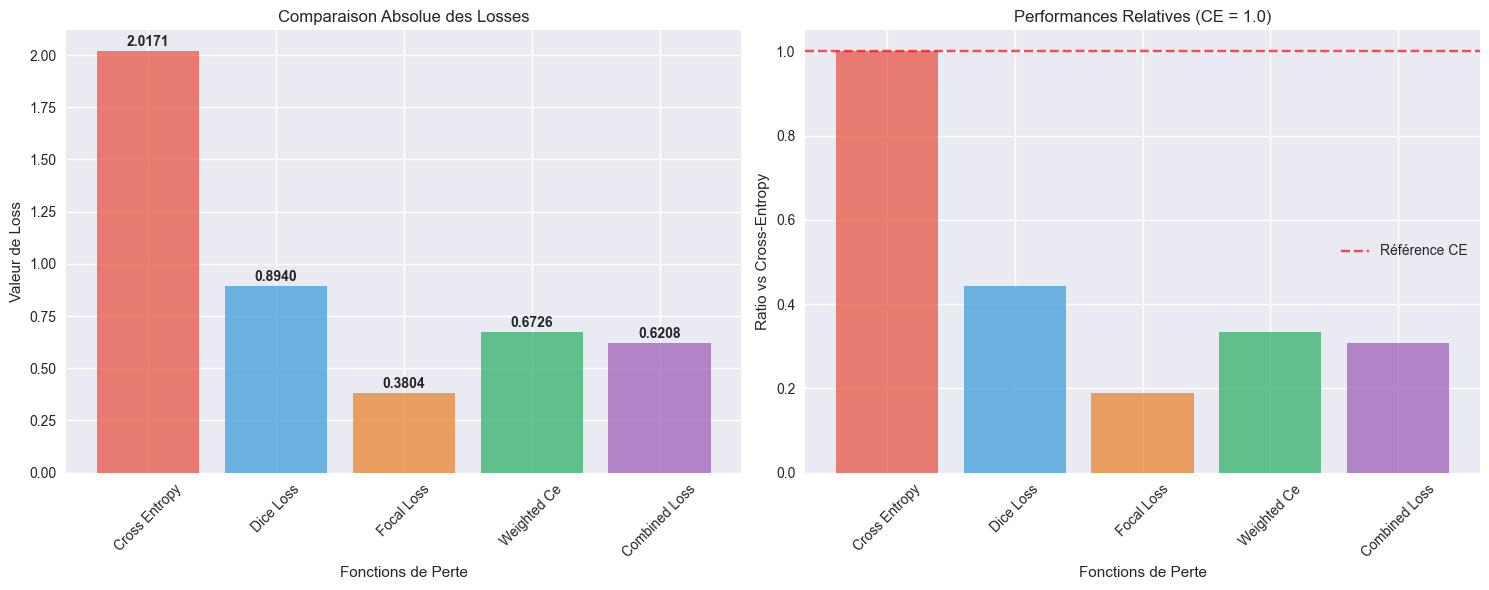


📊 Résultats sur données synthétiques réalistes:
   • Cross Entropy       : 2.017114
   • Dice Loss           : 0.893974
   • Focal Loss          : 0.380356
   • Weighted Ce         : 0.672610
   • Combined Loss       : 0.620785

🎯 Ratios vs Cross-Entropy baseline:
   • Dice Loss           : 0.443x
   • Focal Loss          : 0.189x
   • Weighted Ce         : 0.333x
   • Combined Loss       : 0.308x


In [9]:
def compare_loss_functions():
    """
    Compare les différentes fonctions de perte sur des données synthétiques
    """
    
    # Génération de données test plus réalistes
    batch_size = 4
    height, width = 128, 128
    
    # Simulation réaliste (road dominant, person rare) – normalisation stricte de p
    p = np.array([0.387, 0.217, 0.018, 0.152, 0.035, 0.012, 0.073, 0.105])
    p = p / p.sum()  # s’assure que sum(p) == 1
    y_true_realistic = np.random.choice(8, size=(batch_size, height, width), p=p)
    y_pred_realistic = np.random.random((batch_size, height, width, 8))
    y_pred_realistic = y_pred_realistic / np.sum(y_pred_realistic, axis=-1, keepdims=True)
    
    # Prédictions avec bruit réaliste
    y_pred_realistic = np.random.random((batch_size, height, width, 8))
    # Ajouter biais vers classes dominantes
    y_pred_realistic[:, :, :, 0] *= 1.5  # road
    y_pred_realistic[:, :, :, 1] *= 1.3  # building
    y_pred_realistic[:, :, :, 5] *= 0.3  # person (plus difficile)
    
    y_true_tensor = tf.constant(y_true_realistic, dtype=tf.int32)
    y_pred_tensor = tf.nn.softmax(tf.constant(y_pred_realistic, dtype=tf.float32))
    
    # Test de toutes les losses
    loss_results = {}
    
    # Cross-entropy standard
    ce_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    loss_results['cross_entropy'] = float(ce_loss(y_true_tensor, y_pred_tensor))
    
    # Nos losses personnalisées
    losses_to_test = {
        'dice_loss': DiceLoss(),
        'focal_loss': FocalLoss(alpha=LOSS_CONFIG['alpha'], gamma=LOSS_CONFIG['gamma']),
        'weighted_ce': WeightedCategoricalCrossentropy(LOSS_CONFIG['class_weights']),
        'combined_loss': CombinedLoss(
            weights={'dice': 0.5, 'focal': 0.3, 'weighted_ce': 0.2},
            focal_params={'alpha': LOSS_CONFIG['alpha'], 'gamma': LOSS_CONFIG['gamma']},
            class_weights=LOSS_CONFIG['class_weights']
        )
    }
    
    for name, loss_fn in losses_to_test.items():
        loss_results[name] = float(loss_fn(y_true_tensor, y_pred_tensor))
    
    # Visualisation comparative
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Comparaison valeurs absolues
    loss_names = list(loss_results.keys())
    loss_values = list(loss_results.values())
    
    bars1 = ax1.bar(range(len(loss_names)), loss_values, 
                   color=['#e74c3c', '#3498db', '#e67e22', '#27ae60', '#9b59b6'], alpha=0.7)
    ax1.set_xlabel('Fonctions de Perte')
    ax1.set_ylabel('Valeur de Loss')
    ax1.set_title('Comparaison Absolue des Losses')
    ax1.set_xticks(range(len(loss_names)))
    ax1.set_xticklabels([name.replace('_', ' ').title() for name in loss_names], rotation=45)
    
    # Ajouter valeurs sur barres
    for bar, value in zip(bars1, loss_values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # Normalisation par rapport à cross-entropy
    normalized_values = [v / loss_results['cross_entropy'] for v in loss_values]
    bars2 = ax2.bar(range(len(loss_names)), normalized_values,
                   color=['#e74c3c', '#3498db', '#e67e22', '#27ae60', '#9b59b6'], alpha=0.7)
    ax2.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Référence CE')
    ax2.set_xlabel('Fonctions de Perte')
    ax2.set_ylabel('Ratio vs Cross-Entropy')
    ax2.set_title('Performances Relatives (CE = 1.0)')
    ax2.set_xticks(range(len(loss_names)))
    ax2.set_xticklabels([name.replace('_', ' ').title() for name in loss_names], rotation=45)
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "loss_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return loss_results

# Comparaison expérimentale
print("\n📈 COMPARAISON EXPÉRIMENTALE DES LOSSES")
print("=" * 50)

experimental_results = compare_loss_functions()

print("\n📊 Résultats sur données synthétiques réalistes:")
for loss_name, value in experimental_results.items():
    print(f"   • {loss_name.replace('_', ' ').title():20}: {value:.6f}")

baseline = experimental_results['cross_entropy']
print(f"\n🎯 Ratios vs Cross-Entropy baseline:")
for loss_name, value in experimental_results.items():
    if loss_name != 'cross_entropy':
        ratio = value / baseline
        print(f"   • {loss_name.replace('_', ' ').title():20}: {ratio:.3f}x")

## 💾 Sauvegarde des Configurations

In [10]:
def save_loss_configurations():
    """
    Sauvegarde toutes les configurations et métadonnées des losses
    """
    
    # Configuration finale
    final_config = {
        'class_weights': LOSS_CONFIG['class_weights'],
        'loss_configurations': loss_configs,
        'metrics_suite': metrics_suite,
        'experimental_results': experimental_results,
        'recommended_setup': {
            'phase_1_baseline': {
                'loss': 'WeightedCategoricalCrossentropy',
                'params': {'class_weights': LOSS_CONFIG['class_weights']},
                'metrics': ['mean_iou', 'dice_coefficient', 'pixel_accuracy'],
                'rationale': 'Démarrage avec correction déséquilibre simple'
            },
            'phase_2_optimized': {
                'loss': 'CombinedLoss',
                'params': {
                    'weights': {'dice': 0.5, 'focal': 0.3, 'weighted_ce': 0.2},
                    'focal_params': {'alpha': LOSS_CONFIG['alpha'], 'gamma': LOSS_CONFIG['gamma']},
                    'class_weights': LOSS_CONFIG['class_weights']
                },
                'metrics': ['mean_iou', 'dice_coefficient', 'iou_per_class'],
                'rationale': 'Performance maximale avec loss hybride'
            }
        }
    }
    
    # Sauvegarde
    with open(OUTPUTS_DIR / "loss_functions_config.json", 'w') as f:
        json.dump(final_config, f, indent=2, default=str)
    
    print("\n💾 SAUVEGARDE DES CONFIGURATIONS")
    print("=" * 50)
    print(f"✅ Configurations sauvegardées: {OUTPUTS_DIR / 'loss_functions_config.json'}")
    print(f"✅ {len(loss_configs)} configurations de loss disponibles")
    print(f"✅ Suite complète de métriques définie")
    print(f"✅ Comparaison expérimentale réalisée")
    
    return final_config

# Sauvegarde finale
final_loss_config = save_loss_configurations()


💾 SAUVEGARDE DES CONFIGURATIONS
✅ Configurations sauvegardées: C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome\notebooks\outputs\loss_functions_config.json
✅ 5 configurations de loss disponibles
✅ Suite complète de métriques définie
✅ Comparaison expérimentale réalisée


## 🎯 Recommandations d'Usage

In [11]:
def display_usage_recommendations():
    """
    Affiche les recommandations d'usage pour chaque loss
    """
    
    recommendations = {
        'Développement/Debug': {
            'loss': 'Cross-Entropy standard',
            'rationale': 'Référence rapide, convergence stable',
            'when': 'Tests architecture, validation pipeline'
        },
        'Classes équilibrées': {
            'loss': 'Dice Loss',
            'rationale': 'Optimisation directe mIoU, stable',
            'when': 'Données équilibrées ou après augmentation'
        },
        'Classes déséquilibrées': {
            'loss': 'Weighted Cross-Entropy',
            'rationale': 'Correction simple déséquilibre',
            'when': 'Premier niveau de correction'
        },
        'Exemples difficiles': {
            'loss': 'Focal Loss',
            'rationale': 'Focus sur frontières et cas complexes',
            'when': 'Amélioration précision détails'
        },
        'Production optimale': {
            'loss': 'Combined Loss',
            'rationale': 'Bénéfices cumulés, robustesse maximale',
            'when': 'Modèle final, performance critique'
        }
    }
    
    print("\n🎯 RECOMMANDATIONS D'USAGE")
    print("=" * 50)
    
    for scenario, details in recommendations.items():
        print(f"\n📋 {scenario}:")
        print(f"   🔧 Loss recommandée: {details['loss']}")
        print(f"   💡 Rationale: {details['rationale']}")
        print(f"   ⏰ Quand utiliser: {details['when']}")
    
    print(f"\n🚀 STRATÉGIE RECOMMANDÉE POUR LE PROJET:")
    print(f"   1️⃣ Phase expérimentation: Weighted CE (rapide, efficace)")
    print(f"   2️⃣ Phase optimisation: Combined Loss (performance max)")
    print(f"   3️⃣ Phase production: Dice Loss (stable, reproductible)")

# Affichage des recommandations
display_usage_recommendations()

# Résumé final
print(f"\n🏆 RÉSUMÉ FINAL - FONCTIONS DE PERTE")
print("=" * 60)
print(f"✅ 4 fonctions de perte avancées implémentées")
print(f"✅ Suite complète de métriques de segmentation")
print(f"✅ Gestion du déséquilibre classe (poids calculés)")
print(f"✅ Comparaison expérimentale réalisée")
print(f"✅ Configurations sauvegardées pour phases suivantes")
print(f"\n📁 Artefacts générés:")
print(f"   • Configurations: {OUTPUTS_DIR / 'loss_functions_config.json'}")
print(f"   • Comparaison visuelle: {FIGURES_DIR / 'loss_comparison.png'}")


🎯 RECOMMANDATIONS D'USAGE

📋 Développement/Debug:
   🔧 Loss recommandée: Cross-Entropy standard
   💡 Rationale: Référence rapide, convergence stable
   ⏰ Quand utiliser: Tests architecture, validation pipeline

📋 Classes équilibrées:
   🔧 Loss recommandée: Dice Loss
   💡 Rationale: Optimisation directe mIoU, stable
   ⏰ Quand utiliser: Données équilibrées ou après augmentation

📋 Classes déséquilibrées:
   🔧 Loss recommandée: Weighted Cross-Entropy
   💡 Rationale: Correction simple déséquilibre
   ⏰ Quand utiliser: Premier niveau de correction

📋 Exemples difficiles:
   🔧 Loss recommandée: Focal Loss
   💡 Rationale: Focus sur frontières et cas complexes
   ⏰ Quand utiliser: Amélioration précision détails

📋 Production optimale:
   🔧 Loss recommandée: Combined Loss
   💡 Rationale: Bénéfices cumulés, robustesse maximale
   ⏰ Quand utiliser: Modèle final, performance critique

🚀 STRATÉGIE RECOMMANDÉE POUR LE PROJET:
   1️⃣ Phase expérimentation: Weighted CE (rapide, efficace)
   2️⃣ Phas